# Connectivity

We use the output of the land-tracer experiment. There, we split the domain into four parts and assess connectivity between pairs of compartments.

In [1]:
import xarray as xr
import numpy as np

In [2]:
ds = xr.open_zarr("Globcurr_land.zarr/")
ds = ds.compute()
ds

<xarray.Dataset> Size: 11MB
Dimensions:     (trajectory: 10000, obs: 44)
Coordinates:
  * obs         (obs) int32 176B 0 1 2 3 4 5 6 7 8 ... 36 37 38 39 40 41 42 43
  * trajectory  (trajectory) int64 80kB 5552 9967 0 1 2 ... 9996 9997 9998 9999
Data variables:
    land        (trajectory, obs) float32 2MB 0.0 nan nan nan ... nan nan nan
    lat         (trajectory, obs) float32 2MB -37.58 nan nan nan ... nan nan nan
    lon         (trajectory, obs) float32 2MB 34.87 nan nan nan ... nan nan nan
    time        (trajectory, obs) datetime64[ns] 4MB 2002-01-01 NaT ... NaT NaT
    z           (trajectory, obs) float32 2MB 0.0 nan nan nan ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleAdvectionRK4LandSampleCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.6

We want to split the domain into four compartments:

```
-----
|A|B|
-----
|C|D|
-----
```

So we need the lon and lat values splitting the domain.

In [3]:
lon_line = (ds.lon.min() +  ds.lon.max()) / 2.0
lat_line = (ds.lat.min() +  ds.lat.max()) / 2.0

Then, we create a set of four boolean xarray DataArrays deciding if a particle is within either of the compartments.

In [15]:
in_A = (ds.lon < lon_line) & (ds.lat > lat_line)
in_B = (ds.lon >= lon_line) & (ds.lat > lat_line)
in_C = (ds.lon < lon_line) & (ds.lat <= lat_line)
in_D = (ds.lon >= lon_line) & (ds.lat <= lat_line)

In [5]:
ds["compartment"] = (in_A + 2 * in_B + 3 * in_C + 4 * in_D)  # will be 0 for particles which left the domain
ds["start_compartment"] = ds.compartment.isel(obs=0)
ds = ds.set_coords(["compartment", "start_compartment"])

In [6]:
ds

<xarray.Dataset> Size: 14MB
Dimensions:            (trajectory: 10000, obs: 44)
Coordinates:
  * obs                (obs) int32 176B 0 1 2 3 4 5 6 7 ... 37 38 39 40 41 42 43
  * trajectory         (trajectory) int64 80kB 5552 9967 0 1 ... 9997 9998 9999
    compartment        (trajectory, obs) int64 4MB 4 0 0 0 0 0 0 ... 2 2 0 0 0 0
    start_compartment  (trajectory) int64 80kB 4 4 3 3 3 4 2 3 ... 4 3 2 2 1 1 2
Data variables:
    land               (trajectory, obs) float32 2MB 0.0 nan nan ... nan nan nan
    lat                (trajectory, obs) float32 2MB -37.58 nan nan ... nan nan
    lon                (trajectory, obs) float32 2MB 34.87 nan nan ... nan nan
    time               (trajectory, obs) datetime64[ns] 4MB 2002-01-01 ... NaT
    z                  (trajectory, obs) float32 2MB 0.0 nan nan ... nan nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleAdvectionRK4LandSampleCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.6

In [28]:
connectivity = (
    ds.lat.fillna(0)  # trick: make all positions valid so compartment = 0 will count particles which left domain
    .groupby(["start_compartment", "compartment", "obs"]).count() 
    .rename("connectivity")
)
connectivity /= connectivity.sum("compartment")  # normalize
connectivity.attrs["units"] = "relative"  # set units
connectivity = connectivity.fillna(0)  # connections which are not found are counted 0
connectivity = connectivity.assign_coords(  # add compartment names
    compartment=["X", "A", "B", "C", "D"],  # X for out of domain
    start_compartment=["A", "B", "C", "D"],
)
connectivity

<xarray.DataArray 'connectivity' (start_compartment: 4, compartment: 5, obs: 44)> Size: 7kB
array([[[0.00000000e+00, 0.00000000e+00, 8.01282051e-03, 1.68269231e-02,
         2.40384615e-02, 3.12500000e-02, 3.88621795e-02, 4.60737179e-02,
         4.92788462e-02, 5.64903846e-02, 6.00961538e-02, 6.41025641e-02,
         6.93108974e-02, 7.53205128e-02, 8.05288462e-02, 8.45352564e-02,
         8.81410256e-02, 9.09455128e-02, 9.65544872e-02, 9.89583333e-02,
         1.02564103e-01, 1.04166667e-01, 1.06971154e-01, 1.09375000e-01,
         1.12580128e-01, 1.16987179e-01, 1.19391026e-01, 1.21794872e-01,
         1.25801282e-01, 1.29807692e-01, 1.34615385e-01, 1.38621795e-01,
         1.42227564e-01, 1.47836538e-01, 1.52243590e-01, 1.54647436e-01,
         1.58653846e-01, 1.60657051e-01, 1.63060897e-01, 1.67467949e-01,
         9.98798077e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 9.95993590e-01, 9.85977564e-01, 9.75961538e-01,
         9.67548077e-01, 9.59535256e-01, 9.49919872e-01, 9.42708333e-01,
         9.35496795e-01, 9.24679487e-01, 9.17467949e-01, 9.12660256e-01,
         9.06250000e-01, 8.99038462e-01, 8.92227564e-01, 8.87820513e-01,
         8.83413462e-01, 8.80208333e-01, 8.73798077e-01, 8.72195513e-01,
         8.68589744e-01, 8.68189103e-01, 8.66586538e-01, 8.64583333e-01,
         8.62179487e-01, 8.58173077e-01, 8.56169872e-01, 8.54567308e-01,
         8.50160256e-01, 8.46554487e-01, 8.41746795e-01, 8.38141026e-01,
         8.34535256e-01, 8.28926282e-01, 8.24919872e-01, 8.21314103e-01,
...
         4.47761194e-02, 5.00201694e-02, 5.08269463e-02, 5.32472771e-02,
         5.48608310e-02, 5.68777733e-02, 5.72811618e-02, 6.01048810e-02,
         5.88947156e-02, 5.97014925e-02, 5.92981041e-02, 6.01048810e-02,
         5.97014925e-02, 6.01048810e-02, 6.49455426e-02, 6.41387656e-02,
         6.53489310e-02, 6.97862041e-02, 7.01895926e-02, 7.01895926e-02,
         7.05929810e-02, 7.13997580e-02, 7.46268657e-02, 7.82573618e-02,
         8.10810811e-02, 7.94675272e-02, 7.98709157e-02, 7.90641388e-02,
         8.22912465e-02, 8.51149657e-02, 8.71319080e-02, 8.87454619e-02,
         1.61355385e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.00000000e+00, 9.93142396e-01, 9.79023800e-01, 9.67325534e-01,
         9.52803550e-01, 9.34651069e-01, 9.23356192e-01, 9.10851150e-01,
         8.99959661e-01, 8.89471561e-01, 8.81807180e-01, 8.74546188e-01,
         8.70512303e-01, 8.67285196e-01, 8.59620815e-01, 8.51553046e-01,
         8.40661557e-01, 8.27349738e-01, 8.18475192e-01, 8.05163372e-01,
         7.93465107e-01, 7.81766841e-01, 7.60790641e-01, 7.49092376e-01,
         7.36587334e-01, 7.24889068e-01, 7.13997580e-01, 7.02299314e-01,
         6.93424768e-01, 6.87373941e-01, 6.79306172e-01, 6.67607906e-01,
         6.58733360e-01, 6.49455426e-01, 6.43001210e-01, 6.36546995e-01,
         6.26058895e-01, 6.14764018e-01, 6.03469141e-01, 5.96611537e-01,
         7.66438080e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * obs                (obs) int32 176B 0 1 2 3 4 5 6 7 ... 37 38 39 40 41 42 43
  * compartment        (compartment) <U1 20B 'X' 'A' 'B' 'C' 'D'
  * start_compartment  (start_compartment) <U1 16B 'A' 'B' 'C' 'D'
Attributes:
    axis:           Y
    long_name:      
    standard_name:  latitude
    units:          relative

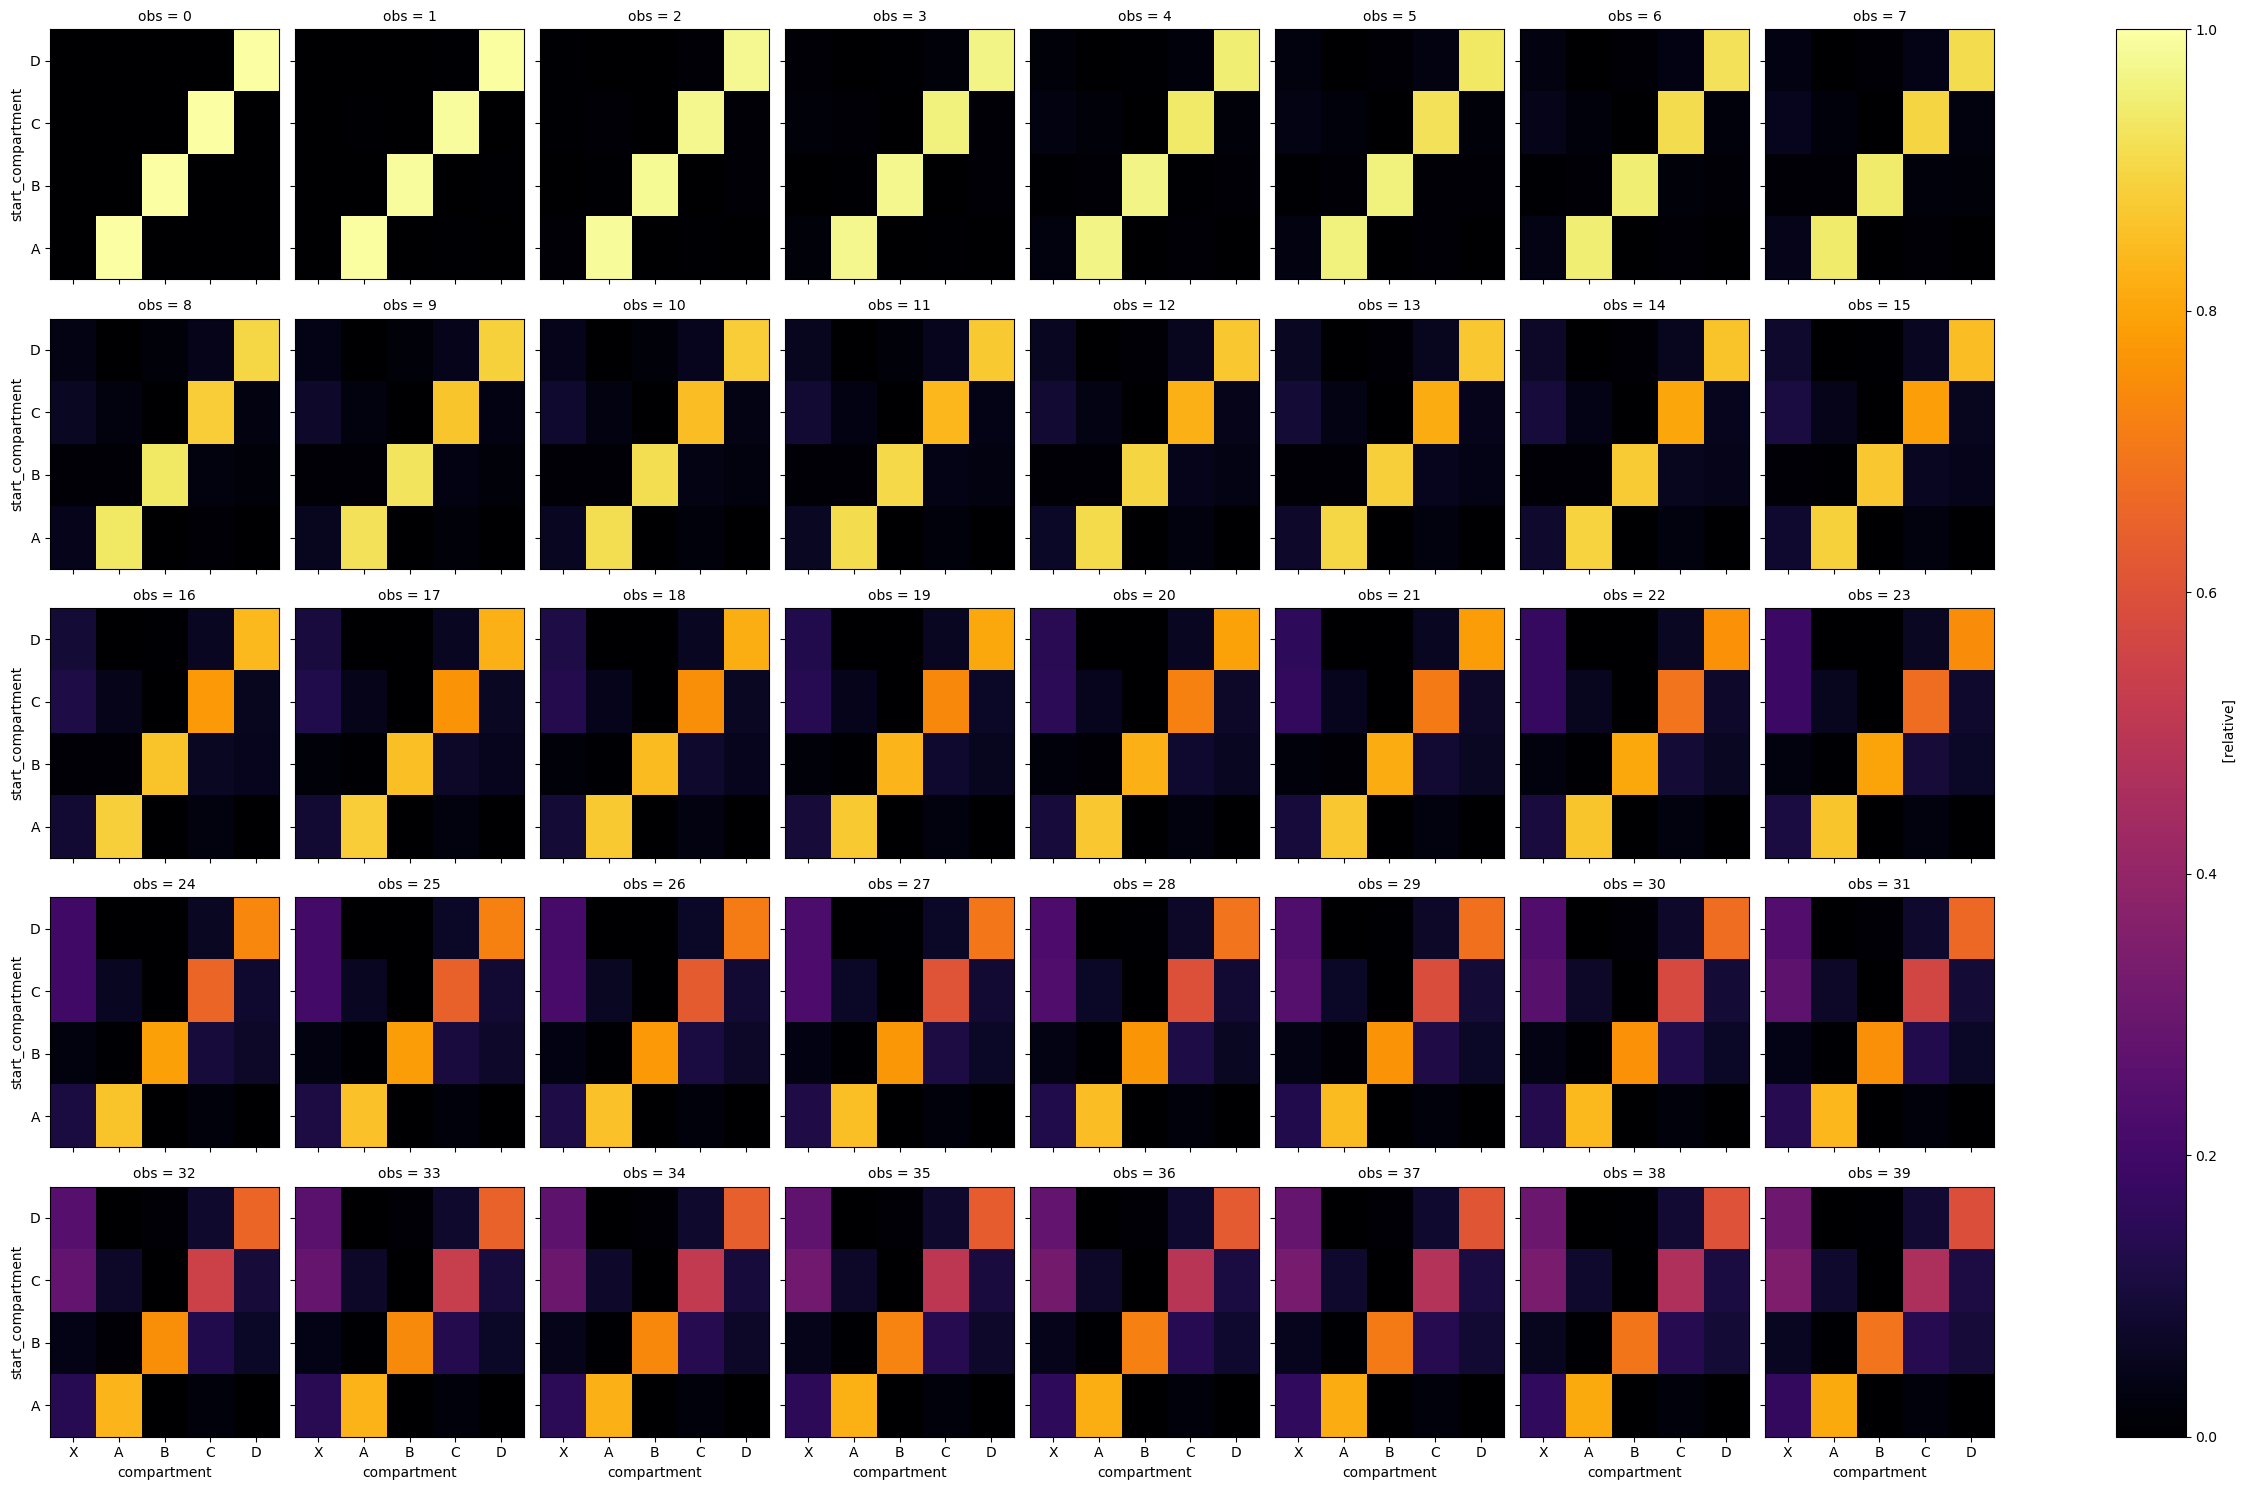

In [31]:
connectivity.isel(obs=slice(None, 40)).plot.imshow(col="obs", col_wrap=8, cmap="inferno")